## Introduction:

**A/B tests** are used to test changes on a web page by running an experiment where a **control group** sees the old version, while the **experiment group** sees the new version. 

A metric is chosen to measure the level of engagement from users in each group. These results are then used to judge whether one version is more effective than the other. A/B testing is very much like hypothesis testing with the following hypotheses:

> *Null Hypothesis: The new version is no better, or even worse, than the old version.*
> *Alternative Hypothesis: The new version is better than the old version.*

If we fail to reject the null hypothesis, the results would suggest keeping the old version. If we reject the null hypothesis, the results would suggest launching the change. These tests can be used for a wide variety of changes, from large feature additions to small adjustments in color, to see what change maximizes your metric the most.

<font color='red'>**A/B testing also has its drawbacks**:
    
<font color='black'>It can help you compare two options, but it can't tell you about an option you haven’t considered. It can also produce bias results when tested on existing users, due to factors like **change aversion** and **novelty effect**.


## Case Study:

In this case study, you’ll analyze A/B test results for Udacity. Here's the customer funnel for typical new users on their site:

**View home page > Explore courses > View course overview page > Enroll in course > Complete course**

Udacity loses users as they go down the stages of this funnel, with only a few making it to the end. To increase student engagement, the company is performing A/B tests to try out changes that will hopefully increase conversion rates from one stage to the next.

<img src="https://www.classcentral.com/report/wp-content/uploads/2018/12/Screenshot_2018-12-18-Udacity-Free-Online-Classes-Nanodegrees-Udacity.jpg" width="400" height="400" />

**First Change**: The first chang is on their homepage. They hope that this new, more engaging design will increase the number of users that explore their courses, that is, move on to the second stage of the funnel.

>Metric: Click through rate (CTR) for the Explore Courses button on the home page
**Formula: clicks by unique users / # views by unique users**


In [1]:
import pandas as pd

df = pd.read_csv('homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


## Exploring Characteristics of the Dataset

In [2]:
# total number of actions
df.shape[0]

8188

In [3]:
# number of unique users
df.id.nunique()

6328

> This is important as the CTR is the number of **unique** visitorrs who click at least once divided by the number of **unique** visitors who view the page. 

In [40]:
# size of control group and experiment group
df.groupby('group').id.nunique()

group
control       3332
experiment    2996
Name: id, dtype: int64

In [5]:
# duration of this experiment
df.timestamp.min(),df.timestamp.max()

('2016-09-24 17:42:27.839496', '2017-01-18 10:24:08.629327')

In [6]:
# action types in this experiment
df.action.value_counts()

view     6328
click    1860
Name: action, dtype: int64

$$H_0: CTR_{new} -  CTR_{old} <=0 $$
$$H_1: CTR_{new} -  CTR_{old} >0 $$ 

## Question: Does the experiment page drive higher traffic than the control page?

###  Steps

1.Compute the observed difference between the metric, click through rate, for the control and experiment group:

In [10]:
control_df=df.query('group=="control"')

In [20]:
control_ctr=control_df.query('action=="click"').id.nunique()/control_df.query('action=="view"').id.nunique()

In [21]:
control_ctr

0.2797118847539016

In [23]:
experiment_df=df.query('group=="experiment"')

In [43]:
experiment_ctr=experiment_df.query('action=="click"').id.nunique()/experiment_df.query('action=="view"').id.nunique()

In [44]:
experiment_ctr

0.3097463284379172

In [51]:
#Observable Difference:
obs_diff=experiment_ctr-control_ctr
print(obs_diff)
f'There is a difference of {round(obs_diff*100,3)}%'

0.030034443684015644


'There is a difference of 3.003%'

2.We have to see if this difference is significant and not just due to chance. Let's **bootstrap** this sample to simulate the **sampling distribution** for the difference in proportions.

In [52]:
diffs=[]
for x in range(10000):
    b_samp=df.sample(df.shape[0],replace=True)
    control_df= b_samp.query('group=="control"')
    experiment_df=b_samp.query('group=="experiment"')
    control_ctr=control_df.query('action=="click"').id.nunique()/control_df.query('action=="view"').id.nunique()
    experiment_ctr=experiment_df.query('action=="click"').id.nunique()/experiment_df.query('action=="view"').id.nunique()
    diffs.append(experiment_ctr-control_ctr)

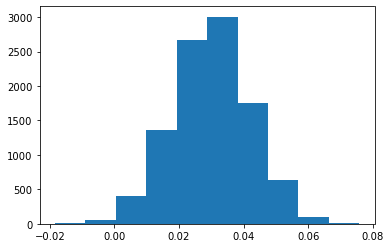

In [53]:
#let's look at our sampling distribution
import matplotlib.pyplot as plt
plt.hist(diffs);

3. We use this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.

In [55]:
import numpy as np
diffs=np.array(diffs)
null_values=np.random.normal(0,diffs.std(),diffs.size)

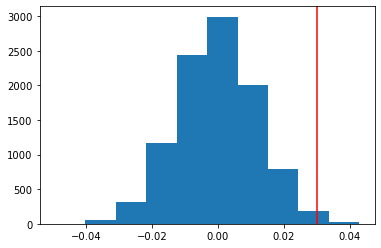

In [57]:
plt.hist(null_values)
plt.axvline(obs_diff,color='red');

4. We compute the p-value by finding the proportion of values in the null distribution that were greater than our observed difference. 

In [59]:
(null_values>obs_diff).mean()

0.0065

> With a P-VALUE of less than 1%, it seems unlikely that our statistic is from the null distribution. **We can reject the null hypothesis**.

> Based on this results, it looks like Udacity should launch the new version of the homepage.

**Second Change**: 
The second change for Udacity is A/B testing a more career focused description on a course overview page. They hope that this change may encourage more users to enroll and complete this course.

**Metrics:**
>1. Enrollment Rate: Click through rate for the Enroll button in the course overview page
2. Average Reading Duration: Average number of seconds spent on the course overview page
3. Average Classroom Time: Average number of days spent in the classroom for students enrolled in the course
4. Completion Rate: Course completion rate for students enrolled in the course

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Exploring Characteristics of the Dataset

Let's explore each metric separately at first:

### 1. Enrollment Rate

In [62]:
df = pd.read_csv('course_page_actions.csv')
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


In [64]:
df.action.value_counts()

view      3260
enroll     814
Name: action, dtype: int64

In [63]:
# dataframe with all records from control group
control_df = df.query('group == "control"')

# Compute click through rate for control group
control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()

# Display click through rate
control_ctr

0.2364438839848676

In [65]:
# dataframe with all records from experiment group
experiment_df = df.query('group == "experiment"')

# Compute click through rate for experiment group
experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()

# Display click through rate
experiment_ctr

0.2668693009118541

In [66]:
# Compute the observed difference in click through rates
obs_diff = experiment_ctr-control_ctr

# Display observed difference
obs_diff

0.030425416926986526

In [67]:
# Create a sampling distribution of the difference in proportions
# with bootstrapping
diffs = []
size = df.shape[0]
for x in range(10000):
    b_samp = df.sample(size, replace=True)
    control_df = b_samp.query('group == "control"')
    experiment_df = b_samp.query('group == "experiment"')
    control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)

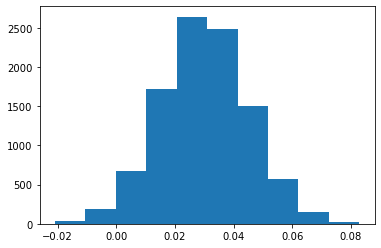

In [68]:
# Convert to numpy array
diffs = np.array(diffs)

# Plot sampling distribution
plt.hist(diffs);

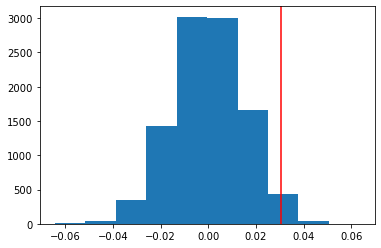

In [71]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0,diffs.std(),diffs.size)

# Plot observed statistic with the null distibution
plt.hist(null_vals)
plt.axvline(obs_diff,color='r');

In [73]:
#Compute P VALUE

(null_vals>obs_diff).mean()

0.0203

> **We can reject the null hypothesis**. With a type I error rate of 0.05, the enrollment rate for this course increases when using the experimental description on its overview page

### 2.Average Reading Duration

¿Does one page engage users for a longer period of time?

In [77]:
#We only care about view action for the reading duration!
views= df.query('action=="view"')

In [92]:
#let's count each unique user once, finding the average reading duration
#if they visited the site more than once

In [97]:
reading_times= views.groupby(['id','group'])['duration'].mean()

In [101]:
reading_times=reading_times.reset_index()

In [103]:
reading_times.head()

,id,group,duration
0,183260,control,107.331484
1,183615,experiment,24.627594
2,184277,experiment,193.212489
3,184360,experiment,226.586283
4,184589,experiment,12.052097


In [110]:
control_mean=reading_times.query('group=="control"').duration.mean()
experiment_mean=reading_times.query('group=="experiment"').duration.mean()
control_mean,experiment_mean

(115.38637100678449, 131.32084104717944)

In [111]:
obs_diff=experiment_mean-control_mean
obs_diff

15.934470040394956

> On average, it looks like users in the experiment group spend 15 more seconds on the course overview page.

Let's see if this difference is significant

In [112]:
diffs=[]
size=reading_times.shape[0]
for x in range(10000):
    b_samp=reading_times.sample(size,replace=True)
    control_mean= b_samp.query('group=="control"').duration.mean()
    experiment_mean=b_samp.query('group=="experiment"').duration.mean()
    diffs.append(experiment_mean-control_mean)

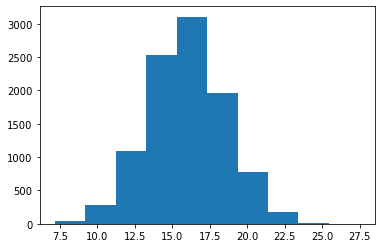

In [113]:
# Convert to numpy array
diffs = np.array(diffs)

# Plot sampling distribution
plt.hist(diffs);

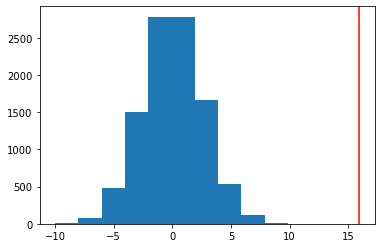

In [115]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0,diffs.std(),diffs.size)

# Plot observed statistic with the null distibution
plt.hist(null_vals)
plt.axvline(obs_diff,color='r');

>It doesnt look like our statistic came from this null distribution. Looks like the difference we observed is significant

In [116]:
#Compute P VALUE

(null_vals>obs_diff).mean()

0.0

### 3.Average Classroom Time

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
df = pd.read_csv('classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [124]:
#The total_days column represnts the total amount of time each student has spent
#in classroom

#Average clasroom time for control group
control_mean = df.query('group == "control"').total_days.mean()

#Average clasroom time for experiment group
experiment_mean = df.query('group == "experiment"').total_days.mean()

control_mean,experiment_mean


(73.36899038461539, 74.6715935334873)

In [125]:
#Observed Difference:
obs_diff=experiment_mean-control_mean
obs_diff

1.3026031488719099

In [126]:
# create sampling distribution of difference in average classroom times
# with boostrapping
diffs = []
size=df.shape[0]
for x in range(10000):
    boot_sam=df.sample(size,replace=True)
    control_mean=boot_sam.query('group == "control"').total_days.mean()
    experiment_mean=boot_sam.query('group == "experiment"').total_days.mean()
    diffs.append(experiment_mean-control_mean)

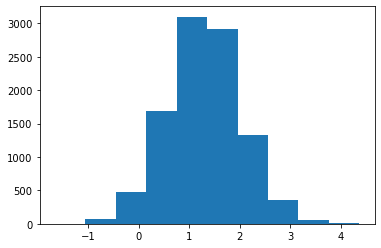

In [134]:
#plot sampling the distribution
plt.hist(diffs);

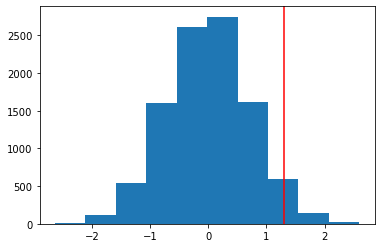

In [136]:
diffs=np.array(diffs)
# simulate distribution under the null hypothesis
null_values=np.random.normal(0,diffs.std(),diffs.size)
#plot the null distribution with the observed statistic
plt.hist(null_values)
plt.axvline(obs_diff, c='red');

In [141]:
#pvalue
(null_values > obs_diff).mean()

0.0346

> We have evidence, with a type I error rate of 0.05, that users spend more time in the classroom after seeing the experimental description in the course overview page. **We can refuse the null hypothesis.**

>Key Note: Even if the increase in classroom time is statistically significant, engaging students for 1.3 more days in the classroom, when they average around 74 days in total, doesn't seem to indicate a large enough value to launch this change from a **practical perspective** for Udacity.

### 4. Completion Rate

In [142]:
df = pd.read_csv('classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


In [146]:
control_mean = df.query('group == "control"').completed.mean()
experiment_mean=df.query('group == "experiment"').completed.mean()

control_mean,experiment_mean

(0.3719951923076923, 0.3935334872979215)

In [151]:
obs_diff=experiment_mean-control_mean
obs_diff

0.02153829499022919

In [152]:
diffs = []
size = df.shape[0]
for _ in range(10000):
    b_samp = df.sample(size, replace=True)
    control_mean = b_samp.query('group == "control"').completed.mean()
    experiment_mean=b_samp.query('group == "experiment"').completed.mean()
    diffs.append(experiment_mean - control_mean)

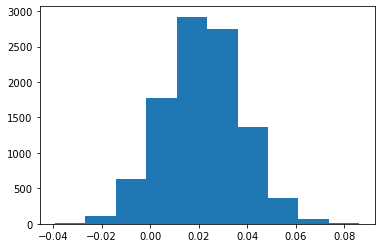

In [153]:
# convert to numpy array
diffs = np.array(diffs)
#plot the sampling distribution
plt.hist(diffs);

In [154]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

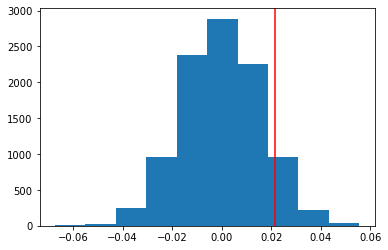

In [155]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, c='red');

In [156]:
# compute p value
(null_vals > obs_diff).mean()

0.0905

> We fail to reject the null 

#### Key Note: The more metrics you evaluate, the more likely you are to observe significant differences just by chance 

Bonferroni Correction: One way we could handle experiments with multiple tests, or metrics in this case. To compute the new bonferroni correct alpha value, we need to divide the original alpha value by the number of tests.


In [159]:
alpha=0.05
tests=4
corrected_alpha=alpha/tests
corrected_alpha

0.0125

Remembering our p-values:
    1. Enrollment Rate: 0.0203
    2. Average Reading Duration: 0
    3. Average Classroom Time: 0.0346
    4. Completion Rate: 0.0905

With the Bonferroni corrected alpha value, only the **Average Reading Duration** produced statistically significant results